### Required software

The following packages were used in this analysis:

In [1]:
with open("requirements.txt", "r") as handle:
    print(handle.read())

bcbio-gff==0.6.2
biopython==1.65
certifi==2015.4.28
ipython==3.1.0
Jinja2==2.7.3
json-schema==0.3
jsonschema==2.4.0
MarkupSafe==0.23
matplotlib==1.4.3
mistune==0.5.1
nose==1.3.6
numpy==1.9.2
pandas==0.16.0
Pillow==2.8.1
ptyprocess==0.4
Pygments==2.0.2
pyparsing==2.0.3
python-dateutil==2.4.2
pytz==2015.2
pyzmq==14.6.0
reportlab==3.1.44
scipy==0.15.1
six==1.9.0
terminado==0.5
tornado==4.1



To run this notebook for yourself create a new [virtual environment](https://virtualenv.pypa.io/en/latest/) in the prompt:

```
$ virtualenv env
$ source env/bin/activate
$ pip install numpy
$ pip install -r requirements
```

Then to run the notebook itself:

```
$ ipython notebook
```

In [2]:
%matplotlib inline

In [3]:
from collections import defaultdict
import os
from os.path import join as pjoin
import subprocess
import re
import json

from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.Graphics.GenomeDiagram import CrossLink
from Bio.Blast.Applications import NcbirpstblastnCommandline
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast.Applications import NcbipsiblastCommandline
from Bio.SeqFeature import SeqFeature
from Bio.SeqFeature import FeatureLocation
from reportlab.lib import colors
from reportlab.lib.units import cm
from BCBio import GFF
from IPython.display import SVG
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [4]:
#plt.style.use('ggplot')

In [5]:
pd.set_option("display.max_colwidth", 800)
pd.options.display.max_rows = 999
THREADS = 2  # Number of CPUs available for calls to BLAST etc.

In [6]:
STEPS = [
    'data',
    "01-found_distribution_of_scaffold_length",
    "02-found_length_distribution_of_scaffolds_with_genes",
    "03-place_candidate_scaffold_lengths_distribution",
    "04-found_dist_nearest_scaf_end_plotted",
    "05-found_distance_nearest_te_gene"
    ]

for step in STEPS:
    if not os.path.isdir(step):
        os.mkdir(step)

## Candidates

Jason identified 10 candidate _AvrRvi5_ genes.
Nine were discovered by comparative genomics, and 1 was discovered by comparative transcriptomics of 14 day old _Venturia inaequalis_ cultures in potato dextrose broth \(PDB\).
`atg10719` was the candidate identified by the transcriptomics method, it is expressed in MNH120 but not in Race 5.

Below is a summary dataframe of the candidates:

In [7]:
CANDIDATES = pd.read_csv(pjoin(STEPS[0], "summary.DNA-seq.RNA-seq.csv"))
CANDIDATES

,method,gene,aa_mutation,length,gb_acc,blast_desc,organism,evalue,identity
0,DNA-seq,atg161,T184I,237,No hit,NaN,NaN,NaN,NaN
1,DNA-seq,atg162,T417A,459,WP_030543571.1,Hypothetical protein,Streptomyces albus,0.000000008,29
2,DNA-seq,atg4020,"P174PNAKPDAKPDAKPDAKP, V155L",185,XP_007283047.1,Snoal-like polyketide cyclase family protein,Colletotrichum gloeosporioides,3E-029,40.15
3,DNA-seq,atg12487,V388M,403,ADT70774.1,Cellobiose dehydrogenase,Dichomera saubinetii,7E-013,55.56
4,DNA-seq,atg140* (not original gene call) first 15 amino acids removed,D83N,232,No hit,NaN,NaN,NaN,NaN
5,DNA-seq,atg7465,V463I,626,EKG19035.1,Glycoside hydrolase family 1,Macrophomina phaesolina,0,75.36
6,DNA-seq,atg10724,"K178N,K239R",292,No hit,NaN,NaN,NaN,NaN
7,DNA-seq,atg10703,G102A,202,No hit,NaN,NaN,NaN,NaN
8,DNA-seq,atg4290,L423S,436,XP_007795436.1,putative chloroperoxidase-like protein [Eutypa lata UCREL1],Eutypa lata,1E-022,38
9,RNA-seq,atg10719,Not expressed in race 5,86,No hit,No hit,No hit,No hit,No hit


In [8]:
CANDIDATES.loc[4,'gene'] = 'atg140'

In [9]:
GENOME_FILES = {
    'MNH120': {
        'fasta': pjoin(STEPS[0], 'MNH120.genome.masked.fasta'),
        'gff': [
            pjoin(STEPS[0], 'augustus.hints.GeneWithUTR.withNCBI_Fungi.gff3'),
            pjoin(STEPS[0], 'MNH120.REPET_TEs.gff3'),
            pjoin(STEPS[0], 'MNH120.REPET_SSRs.gff3'),
            ]
        },
    'B04': {
        'fasta': pjoin(STEPS[0], 'B04.genome.fa'),
        'gff': [
            pjoin(STEPS[0], 'B04.genes.gff3'),
            ]
        },
    'USR5': {
        'fasta': pjoin(STEPS[0], 'I5V.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I5V.PredictedPass.cleaned.gff3'),
            ]
        },
    'I9A': {
        'fasta': pjoin(STEPS[0], 'I9A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I9A.PredictedPass.cleaned.gff3'),
            ]
        },
    'I17V': {
        'fasta': pjoin(STEPS[0], 'I17V.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I17V.PredictedPass.cleaned.gff3'),
            ]
        },
    'I19A': {
        'fasta': pjoin(STEPS[0], 'I19A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I19A.PredictedPass.cleaned.gff3'),
            ]
        },
    'I31A': {
        'fasta': pjoin(STEPS[0], 'I31A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I31A.gapfilled.final.cleaned.gff3'),
            ],
        },
    'I37A': {
        'fasta': pjoin(STEPS[0], 'I37A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I37A.PredictedPass.cleaned.gff3'),
            ],
        },
    'I61A': {
        'fasta': pjoin(STEPS[0], 'I61A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I61A.PredictedPass.cleaned.gff3'),
            ],
        },
    'I65V': {
        'fasta': pjoin(STEPS[0], 'I65V.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS[0], 'I65V.PredictedPass.cleaned.gff3'),
            ],
        }
    }

In [10]:
GENOMES = dict()
for isolate, files in GENOME_FILES.items():
    GENOMES[isolate] = SeqIO.to_dict(
        SeqIO.parse(files['fasta'], format="fasta")
        )

    for gff in files['gff']:
        genome_with_features = GFF.parse(
            gff,
            base_dict=GENOMES[isolate]
            )
        GENOMES[isolate].update(SeqIO.to_dict(genome_with_features))

In [11]:
GENES = dict()
GENES['MNH120'] = SeqIO.to_dict(
    SeqIO.parse(pjoin(STEPS[0], 'MNH120.Auto.genes.fna'), format="fasta")
    )

In [12]:
cdict = {
    'red':   ((0., 59/256, 59/256),
              (0.25, 120/256, 120/256),
              (0.5, 235/256, 235/236),
              (0.75, 225/256, 225/256),
              (1., 242/256, 242/256)),
    'green': ((0., 156/256, 156/256),
              (0.25, 183/256, 183/256),
              (0.5, 204/256, 204/256),
              (0.75, 175/256, 175/256),
              (1., 26/256, 26/256)),
    'blue':  ((0., 178/256, 178/256),
              (0.25, 197/256, 197/256),
              (0.5, 42/256, 42/256),
              (0.75, 0., 0.),
              (1., 0., 0.))
    }

zissou = LinearSegmentedColormap('Zissou', cdict)
plt.register_cmap(cmap=zissou)

cat_colours = ["#FF0000", "#00A08A", "#F2AD00", "#F98400", "#5BBCD6", "#046C9A", '#35274A', '#B40F20', "#D69C4E"]

In [13]:
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  

### Step 01 - found distribution of scaffold length

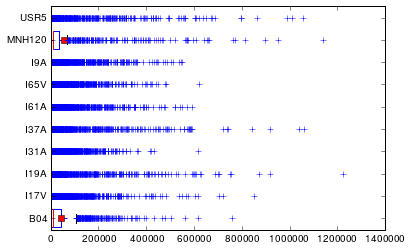

In [14]:
scaffold_lengths = list()

for isolate, genome in GENOMES.items():
    for scaffold, sequence in genome.items():
        row = {
            'isolate': isolate,
            'scaffold': scaffold,
            'length': len(sequence)
            }
        scaffold_lengths.append(row)

scaffold_lengths = pd.DataFrame(scaffold_lengths)
scaffold_lengths.to_csv(
    pjoin(STEPS[1], 'scaffold_lengths.csv'),
    index=False,
    sep='\t',
    encoding='utf-8',
    header=True
    )

isolate_names = list()
isolate_lengths = list()
for i, j in scaffold_lengths.groupby(['isolate'])['length']:
    isolate_names.append(i)
    isolate_lengths.append(j.values)
fig, ax = plt.subplots()
dummy = ax.boxplot(isolate_lengths, labels=isolate_names, vert=False, showmeans=True, widths=0.8)
fig.savefig(pjoin(STEPS[1], 'scaffold_distribution.png'))

### Step 02 - looking again only at scaffolds with genes

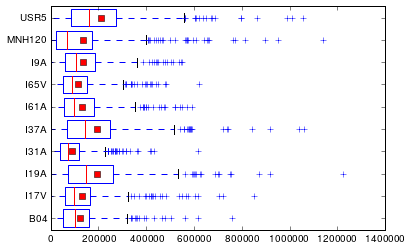

In [15]:
scaffold_lengths_genes = list()

for isolate, genome in GENOMES.items():
    for scaffold, sequence in genome.items():
        if len([f for f in sequence.features if f.type == 'gene']) == 0:
            continue
        row = {
            'isolate': isolate,
            'scaffold': scaffold,
            'length': len(sequence)
            }
        scaffold_lengths_genes.append(row)

scaffold_lengths_genes = pd.DataFrame(scaffold_lengths_genes)
scaffold_lengths_genes.to_csv(
    pjoin(STEPS[2], 'scaffold_lengths_containing_genes.csv'),
    index=False,
    sep='\t',
    encoding='utf-8',
    header=True
    )

isolate_names = list()
isolate_lengths = list()
for i, j in scaffold_lengths_genes.groupby(['isolate'])['length']:
    isolate_names.append(i)
    isolate_lengths.append(j.values)
fig, ax = plt.subplots()
dummy = ax.boxplot(isolate_lengths, labels=isolate_names, vert=False, showmeans=True, widths=0.8)
fig.savefig(pjoin(STEPS[2], 'scaffold_distribution.png'))

### Step 03 - place candidate scaffold lengths in distribution

In [16]:
with open(pjoin(STEPS[0], 'MNH120_candidate_homologues.json'), 'r') as handle:
    candidate_homologues = json.load(handle)

positions = defaultdict(dict)
for candidate in CANDIDATES['gene']:
    print(candidate)
    for isolate, homologues in candidate_homologues[candidate].items():
        homologue = homologues[0]
        scaffold = homologue['scaffold']
        positions[candidate][isolate] = len(GENOMES[isolate][scaffold])
        print("{:>8}:".format(isolate), len(GENOMES[isolate][scaffold]))
    
with open(pjoin(STEPS[3], 'candidate_scaf_lengths.json'), 'w') as handle:
    json.dump(positions, handle)

atg161
    I19A: 148984
    I65V: 336338
  MNH120: 65488
    I37A: 1058651
    USR5: 249012
    I61A: 111918
     B04: 99402
     I9A: 106603
    I31A: 67120
    I17V: 615942
atg162
    I19A: 148984
    I65V: 336338
  MNH120: 65488
    I37A: 1058651
    USR5: 249012
    I61A: 111918
     B04: 99402
     I9A: 106603
    I31A: 67120
    I17V: 615942
atg4020
    I19A: 407893
    I65V: 241990
  MNH120: 9883
    I37A: 1058651
    USR5: 306619
    I61A: 223483
     B04: 112942
     I9A: 238720
    I31A: 55337
    I17V: 615942
atg12487
    I19A: 236498
    I65V: 336338
  MNH120: 656374
    I37A: 294686
    USR5: 249012
    I61A: 235822
     B04: 173445
     I9A: 226476
    I31A: 107040
    I17V: 615942
atg140
    I19A: 261048
    I65V: 173274
  MNH120: 25314
    I37A: 89232
    USR5: 605022
    I61A: 539802
     B04: 104567
     I9A: 154533
    I31A: 65464
    I17V: 290198
atg7465
    I19A: 148984
    I65V: 336338
  MNH120: 103197
    I37A: 1058651
    USR5: 249012
    I61A: 111918
     B04: 

### Step 04 - Find distance to nearest scaffold end.

In [17]:
%run lib/subset_features.py

In [18]:
all_scaffold_lengths = list()
for isolate, scaffolds in GENOMES.items():
    for scaffold, record in scaffolds.items():
        for feat in record.features:
            if feat.type != 'gene':
                continue
            distance = min([
                feat.location.start,
                feat.location.end,
                len(record) - feat.location.start,
                len(record) - feat.location.end
                ])
            row = {
                'feature': feat.id,
                'isolate': isolate,
                'scaffold': scaffold,
                'length': len(record),
                'distance': distance
                }
            all_scaffold_lengths.append(row)

all_scaffold_lengths = pd.DataFrame(all_scaffold_lengths)
all_scaffold_lengths.to_csv(
    pjoin(STEPS[4], 'all_scaffold_lengths.csv'),
    index=False,
    sep='\t',
    encoding='utf-8',
    header=True
    )

with open(pjoin(STEPS[0], 'MNH120_candidate_homologues.json'), 'r') as handle:
    candidate_homologues = json.load(handle)

# candidate: genome: scaffold: feature1, feature2, ...
features = defaultdict(lambda: defaultdict(lambda: defaultdict(set)))
scaffold_lengths = list()
for candidate in CANDIDATES['gene']:
    for isolate, homologues in candidate_homologues[candidate].items():
        homologue = homologues[0]
        scaffold = homologue['scaffold']
        these_features = subset_features(
            GENOMES[isolate][scaffold],
            homologue['start'],
            homologue['end']
            )
        these_features = [f for f in these_features if f.type == 'gene']
        if len(these_features) == 0:
            feature = SeqFeature(
                location=FeatureLocation(
                    homologue['start'],
                    homologue['end'],
                    homologue['strand'],
                    ),
                id=isolate + '_' + candidate + '_homologue',
                )
            features[candidate][isolate][scaffold] = feature
        else:
            feature = these_features[0]
            features[candidate][isolate][scaffold] = feature

        distance = min([
            feature.location.start,
            feature.location.end,
            len(GENOMES[isolate][scaffold]) - feature.location.start,
            len(GENOMES[isolate][scaffold]) - feature.location.end
            ])
        row = {
            'candidate': candidate,
            'feature': feature.id,
            'isolate': isolate,
            'scaffold': scaffold,
            'length': len(GENOMES[isolate][scaffold]),
            'distance': distance
            }
        scaffold_lengths.append(row)

candidate_scaffold_lengths = pd.DataFrame(scaffold_lengths)
candidate_scaffold_lengths.to_csv(
    pjoin(STEPS[4], 'candidate_scaffold_lengths.csv'),
    index=False,
    sep='\t',
    encoding='utf-8',
    header=True
    )

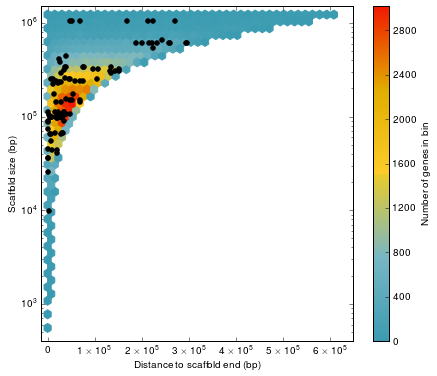

In [21]:
all_scaffold_lengths = pd.read_table(pjoin(STEPS[4], 'all_scaffold_lengths.csv'))

candidate_scaffold_lengths = pd.read_table(pjoin(STEPS[4], 'candidate_scaffold_lengths.csv'))

fig, ax = plt.subplots()
hexbin = ax.hexbin(
    x=all_scaffold_lengths['distance'].values, 
    y=all_scaffold_lengths['length'].values,
    cmap=zissou,
    yscale='log',
    gridsize=40,
    )
cbar = plt.colorbar(hexbin, ax=ax)
cbar.set_label('Number of genes in bin')
if len(hexbin._offsets) == 1:
    mask = list()
    for i, path in enumerate(hexbin._paths):
        if (path._vertices[0][0] / path._vertices[0][1] > 0.5) & \
                (hexbin._A[i] == 0.):
            mask.append(True)
        else:
            mask.append(False)
    mask = np.array(mask)
else:
    mask = (hexbin._offsets[:, 0] / hexbin._offsets[:, 1] >= 1/2) & \
                (hexbin._A == 0.)
hexbin._A = np.ma.masked_where(mask, hexbin._A)

scatter = ax.scatter(
    x=candidate_scaffold_lengths['distance'].values,
    y=candidate_scaffold_lengths['length'].values,
    color='#000000',
    )
ax.set_xlim(-15000, 6.5e+5)
xticklabels = ax.set_xticklabels([0, 0] + [r'${} \times 10^{{5}}$'.format(i) for i in range(1, 7)])
#ax.autoscale()
ax.set_ylim(400, 1.5 * 10**6)
ax.set_ylabel('Scaffold size (bp)')
ax.set_xlabel('Distance to scaffold end (bp)')
fig.set_size_inches(7, 6)
fig.savefig(pjoin(STEPS[4], "scaf_dist_all.png"), dpi=300)
fig.savefig(pjoin(STEPS[4], "scaf_dist_all.pdf"))
fig.savefig(pjoin(STEPS[4], "scaf_dist_all.svg"))

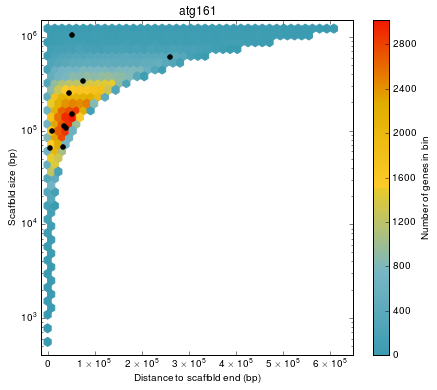

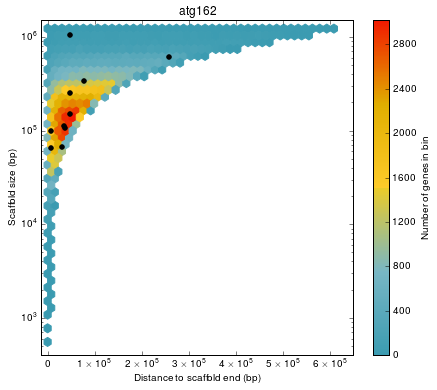

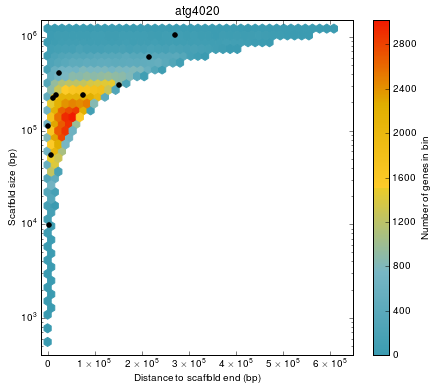

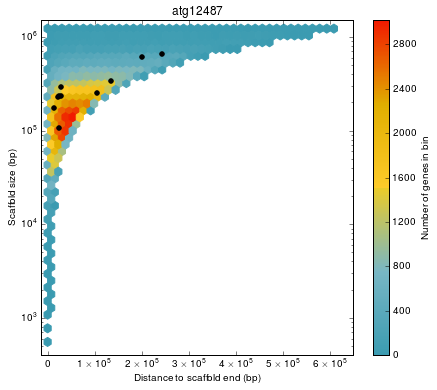

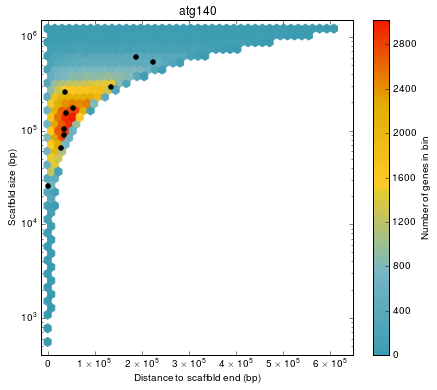

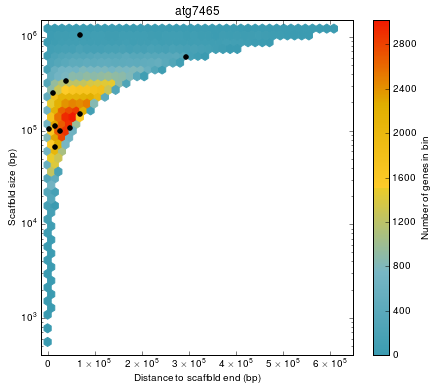

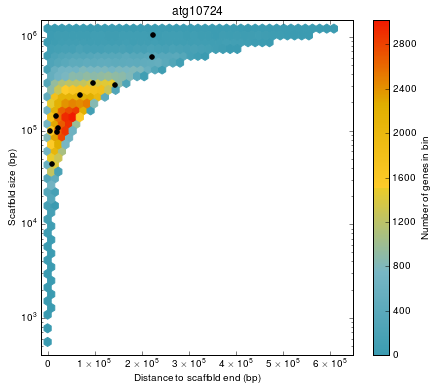

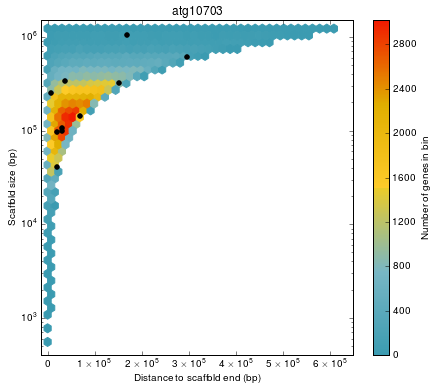

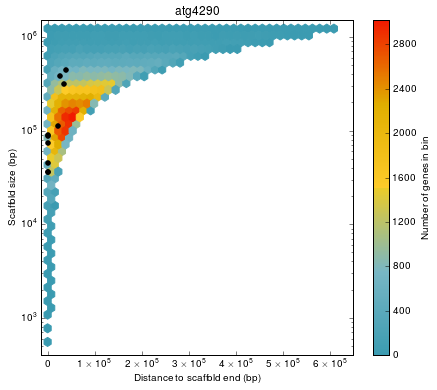

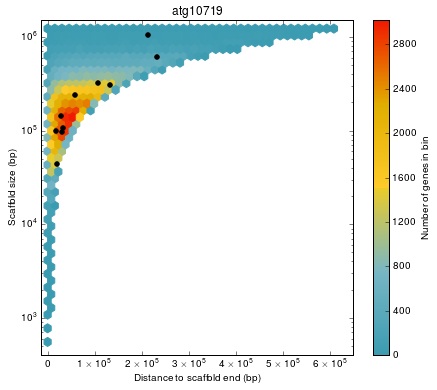

In [22]:
candidates = list(CANDIDATES['gene'])

for candidate in candidates:
    fig, ax = plt.subplots()
    hexbin = ax.hexbin(
        x=all_scaffold_lengths['distance'].values, 
        y=all_scaffold_lengths['length'].values,
        cmap=zissou,
        yscale='log',
        gridsize=40,
        )
    cbar = plt.colorbar(hexbin, ax=ax)
    cbar.set_label('Number of genes in bin')
    if len(hexbin._offsets) == 1:
        mask = list()
        for i, path in enumerate(hexbin._paths):
            if (path._vertices[0][0] / path._vertices[0][1] > 0.5) & \
                    (hexbin._A[i] == 0.):
                mask.append(True)
            else:
                mask.append(False)
        mask = np.array(mask)
    else:
        mask = (hexbin._offsets[:, 0] / hexbin._offsets[:, 1] >= 1/2) & \
                    (hexbin._A == 0.)
    hexbin._A = np.ma.masked_where(mask, hexbin._A)

    scatter = ax.scatter(
        x=candidate_scaffold_lengths[
            candidate_scaffold_lengths.candidate == candidate
            ]['distance'].values,
        y=candidate_scaffold_lengths[
            candidate_scaffold_lengths.candidate == candidate
            ]['length'].values,
        color='#000000',
        )
    ax.set_xlim(-15000, 6.5e+5)
    xticklabels = ax.set_xticklabels([0, 0] + [r'${} \times 10^{{5}}$'.format(i) for i in range(1, 7)])
    #ax.autoscale()
    ax.set_ylim(400, 1.5 * 10**6)
    ax.set_ylabel('Scaffold size (bp)')
    ax.set_xlabel('Distance to scaffold end (bp)')
    ax.set_title(candidate)
    fig.set_size_inches(7, 6)
    fig.savefig(pjoin(STEPS[4], "scaf_dist_{}.png".format(candidate)), dpi=300)
    fig.savefig(pjoin(STEPS[4], "scaf_dist_{}.pdf".format(candidate)))
    fig.savefig(pjoin(STEPS[4], "scaf_dist_{}.svg".format(candidate)))

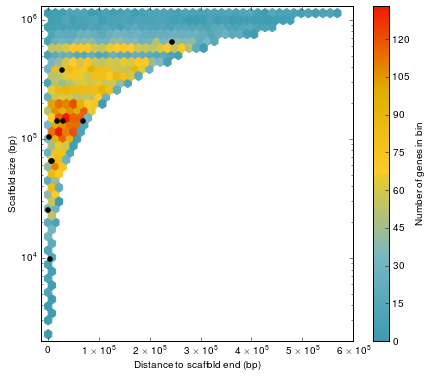

In [23]:
candidate = 'atg4020'

fig, ax = plt.subplots()
hexbin = ax.hexbin(
    x=all_scaffold_lengths[
        all_scaffold_lengths.isolate == 'MNH120'
        ]['distance'].values, 
    y=all_scaffold_lengths[
        all_scaffold_lengths.isolate == 'MNH120'
        ]['length'].values,
    cmap=zissou,
    yscale='log',
    gridsize=40,
    )

if len(hexbin._offsets) == 1:
    mask = list()
    for i, path in enumerate(hexbin._paths):
        if (path._vertices[0][0] / path._vertices[0][1] > 0.5) & \
                (hexbin._A[i] == 0.):
            mask.append(True)
        else:
            mask.append(False)
    mask = np.array(mask)
else:
    mask = (hexbin._offsets[:, 0] / hexbin._offsets[:, 1] >= 1/2) & \
                (hexbin._A == 0.)
hexbin._A = np.ma.masked_where(mask, hexbin._A)

cbar = plt.colorbar(hexbin, ax=ax)
cbar.set_label('Number of genes in bin')
scatter = ax.scatter(
    x=candidate_scaffold_lengths[
        candidate_scaffold_lengths.isolate == 'MNH120'
        ]['distance'].values,
    y=candidate_scaffold_lengths[
        candidate_scaffold_lengths.isolate == 'MNH120'
        ]['length'].values,
    color='#000000'
    )

ax.set_xlim(-15000, 6e+5)
xticklabels = ax.set_xticklabels([0, 0] + [r'${} \times 10^{{5}}$'.format(i) for i in range(1, 7)])
#ax.autoscale()
ax.set_ylim(2000, 1.3 * 10**6)
ax.set_ylabel('Scaffold size (bp)')
ax.set_xlabel('Distance to scaffold end (bp)')
fig.set_size_inches(7, 6)
fig.savefig(pjoin(STEPS[4], "scaf_dist_mnh120.png"), dpi=300)
fig.savefig(pjoin(STEPS[4], "scaf_dist_mnh120.pdf"))
fig.savefig(pjoin(STEPS[4], "scaf_dist_mnh120.svg"))

### Step 05 - find distance to nearest TE-Gene

In [22]:
# Preprocessing genome
## Super inefficient implementation

rows = list()
for isolate, genome in GENOMES.items():
    if isolate != 'MNH120':
        continue
        # We currently only have REPET data for MNH120, others to come.
    for scaffold, sequence in genome.items():
        these_tes = [f for f in sequence.features if ('te' in f.type.lower() or 'ssr' in f.type.lower())]
        these_genes = [f for f in sequence.features if f.type == 'gene']
        
        ## sort by min(feature.start, feature.end)
        #these_tes.sort(key=lambda f: min(f.location.start, f.location.end))
        #these_genes.sort(key=lambda f: min(f.location.start, f.location.end))

        if len(these_genes) == 1:  # Can't find nearest gene in this case
            continue
        if len(these_tes) == 0:  # Can't find nearest te in this case
            continue

        for i, gene in enumerate(these_genes):
            id_ = gene.id 
            start = gene.location.start
            end = gene.location.end
            
            min_gene_dist = float('inf')
            for j, n_gene in enumerate(these_genes):
                if j == i:
                    continue
                n_start = n_gene.location.start
                n_end = n_gene.location.end
                gene_dist = min(
                    abs(start - n_start),
                    abs(start - n_end),
                    abs(end - n_start),
                    abs(end - n_end),
                    )
                if gene_dist < min_gene_dist:
                    min_gene_dist = gene_dist

            min_te_dist = float('inf')
            for te in these_tes:
                te_start = te.location.start
                te_end = te.location.end
                te_dist = min(
                    abs(start - te_start),
                    abs(start - te_end),
                    abs(end - te_start),
                    abs(end - te_end),
                    )
                if te_dist < min_te_dist:
                    min_te_dist = te_dist

            row = {
                'isolate': isolate,
                'scaffold': scaffold,
                'feature': id_,
                'nearest_gene': min_gene_dist,
                'nearest_te': min_te_dist
                }
            rows.append(row)
rows = pd.DataFrame(rows)
rows.loc[rows['nearest_te'] <= 0., 'nearest_te'] = 1
rows.to_csv(pjoin(STEPS[5], 'nearest_gene_te.csv'), sep='\t', index=False)

Because I am going to plot these on a log scale, any zero values will screw up the plot because log(0) = -infinity.
I changed those values to 1.

In [23]:
rows = pd.read_table(pjoin(STEPS[5], 'nearest_gene_te.csv'), sep='\t')
candidates = set(CANDIDATES['gene'])
candidate_pos = rows[rows['feature'].isin(candidates)]
candidate_pos

,feature,isolate,nearest_gene,nearest_te,scaffold
2815,atg10703,MNH120,281,976,scaffold_996
2831,atg10719,MNH120,841,345,scaffold_996
2836,atg10724,MNH120,107,4126,scaffold_996
4219,atg161,MNH120,647,20,scaffold_48
4220,atg162,MNH120,797,214,scaffold_48
4308,atg7465,MNH120,622,24,scaffold_893
5614,atg12487,MNH120,682,155,scaffold_978
7826,atg140,MNH120,11265,1,scaffold_38
9724,atg4290,MNH120,202,7,scaffold_447


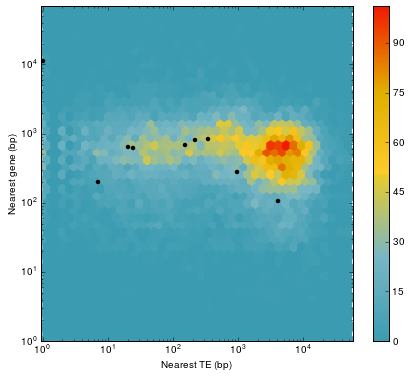

In [24]:
rows = pd.read_table(pjoin(STEPS[5], 'nearest_gene_te.csv'), sep='\t')

fig, ax = plt.subplots()
im = ax.hexbin(
    x=rows['nearest_te'].values,
    y=rows['nearest_gene'].values,
    cmap=zissou,
    yscale='log',
    xscale='log',
    gridsize=40,
    )
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Number of genes in bin')
#ax.set_xlim(-1, 10**5)
ax.autoscale

scatter = ax.scatter(
    x=candidate_pos['nearest_te'].values,
    y=candidate_pos['nearest_gene'].values,
    c='#000000',
    lw=0.,
    #alpha=.70,
    )

ax.set_ylabel('Nearest gene (bp)')
ax.set_xlabel('Nearest TE (bp)')
fig.set_size_inches(7, 6)
fig.savefig(pjoin(STEPS[5], 'heatmap_te_gene.png'), dpi=300, )
fig.savefig(pjoin(STEPS[5], 'heatmap_te_gene.pdf'))
fig.savefig(pjoin(STEPS[5], 'heatmap_te_gene.svg'))
plt.show()